In [1]:
import os
from functools import reduce
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import statsmodels.api as sm

In [2]:
# --- DATA
# full path to folder with data to process
data = os.getcwd()  # the current working directory

rivers = ('Aripo', 'Quare', 'Yarra')
pops = ('High', 'Low')
colours = ('black', 'darkorange')

# suffixes for input files (MUST be prefixed by `river` and `pop`, e.g. "river-pop.suffix")
in_suffix = 'sw50kb-sites1-orphans.MF.logCovSnp.tsv'
out_suffix = 'byPop.sw50kb-sites1-orphans.pdf'
# Rolling mean
roll = 20
min_periods = 5

sex_ctgs = ['NC_024342.1']
strata = [20, 26]  # in Mb

if strata:
    strata = [i * 10e5 for i in strata]
    
strata

[20000000.0, 26000000.0]

In [3]:
# --- READ FILES INTO DF
readDF_args = {'header': 0, 'sep': '\t'}
frames = []
for r in rivers:
    for p in pops:
        buff = pd.read_csv('{}/{}-{}.{}'.format(data, r, p, in_suffix), **readDF_args)
        buff['chrom'] = buff['chrom'].str.replace('_RaGOO', '').str.replace('_RaGOO', '')
        buff['river'] = r
        buff['pop'] = p
        frames.append(buff)


df = pd.concat(frames, ignore_index=True)
df.head()
df.tail()


,chrom,pos,logCov,logSnp,river,pop
0,NC_024331.1,25000,0.149892,-0.076689,Aripo,High
1,NC_024331.1,75000,0.196718,-0.218492,Aripo,High
2,NC_024331.1,125000,0.080386,-0.260192,Aripo,High
3,NC_024331.1,175000,0.057433,-0.277518,Aripo,High
4,NC_024331.1,225000,0.097395,-0.333892,Aripo,High


,chrom,pos,logCov,logSnp,river,pop
86515,NC_024353.1,18811869,NaN,NaN,Yarra,Low
86516,NC_024353.1,18811874,NaN,NaN,Yarra,Low
86517,NC_024353.1,18811875,NaN,NaN,Yarra,Low
86518,NC_024353.1,18811877,NaN,NaN,Yarra,Low
86519,NC_024353.1,18811878,NaN,NaN,Yarra,Low


In [4]:
# --- ROLLING MEAN
def doRolling(df, group, colname, window, minperiods):
    '''
    Perform rolling mean over 'colname' for each 'group' list
    '''
    return df.groupby(group, as_index=False)[colname].rolling(window, center=True, min_periods=minperiods) \
            .mean().reset_index(0, drop=True)


df.sort_values(by=['river', 'pop', 'chrom', 'pos'], inplace=True)
# for rolling, we MUST reset the index after sorting
df.reset_index(inplace=True, drop=True)

for x in ['logCov', 'logSnp']:
    df['{}_roll'.format(x)] = doRolling(df, ['river', 'pop', 'chrom'], x, roll, min_periods)

df.head()

,chrom,pos,logCov,logSnp,river,pop,logCov_roll,logSnp_roll
0,NC_024331.1,25000,0.149892,-0.076689,Aripo,High,0.112844,-0.438155
1,NC_024331.1,75000,0.196718,-0.218492,Aripo,High,0.115432,-0.459379
2,NC_024331.1,125000,0.080386,-0.260192,Aripo,High,0.117907,-0.455789
3,NC_024331.1,175000,0.057433,-0.277518,Aripo,High,0.119521,-0.427608
4,NC_024331.1,225000,0.097395,-0.333892,Aripo,High,0.110792,-0.379085


In [5]:
# --- BOOTSTRAP
def bootstrap(dat, size, iterations=1000, ci=0.95):
    '''
    Calculates the percentile bootstrap
    '''
    # exclude nan from original data
    dat = dat[np.logical_not(np.isnan(dat))]
    stats = []
    for i in range(iterations):
        # sample with replacement
        sample = np.random.choice(dat, size=size, replace=True)
        # for each sample, calculate the mean value
        stats.append(np.mean(sample))

    stats = sorted(stats)
    p = ((1.0 - ci) / 2.0) * 100
    lower = np.percentile(stats, p)
    p = (ci + ((1.0 - ci) / 2.0)) * 100
    upper = np.percentile(stats, p)

    return lower, upper


# get the bootstrap estimates for the size of a single window (excluding sex chromosome)
# this is done by river only to get a single inverval
boots = defaultdict(dict)
for r in rivers:
    for x in ['logCov', 'logSnp']:
        tmp = df.loc[(~df['chrom'].isin(sex_ctgs)) & (df['river'] == r)][x]
        boot_low, boot_high = bootstrap(tmp, roll, iterations=1000, ci=0.95)
        boots[r][x] = (boot_low, boot_high)

boots

defaultdict(dict,
            {'Aripo': {'logCov': (-0.04440829915546597, 0.04131220639180449),
              'logSnp': (-0.2018127346037516, 0.12494956570469923)},
             'Quare': {'logCov': (-0.04434229843105649, 0.03703860337174111),
              'logSnp': (-0.15057773966601373, 0.1260284657909517)},
             'Yarra': {'logCov': (-0.03648145043546356, 0.028561582348298663),
              'logSnp': (-0.22667300231601098, 0.16661242139053412)}})

In [6]:
# --- FILTER FOR SEX CHROMOSOME
sex_df = df.loc[df['chrom'].isin(sex_ctgs)]
sex_df.shape
sex_df.head()
sex_df.tail()
sex_df.describe()

(3304, 8)

,chrom,pos,logCov,logSnp,river,pop,logCov_roll,logSnp_roll
7561,NC_024342.1,25000,-0.086529,0.272053,Aripo,High,-0.009272,0.257521
7562,NC_024342.1,75000,-0.044634,0.137685,Aripo,High,0.000422,0.235997
7563,NC_024342.1,125000,-0.039125,-0.085987,Aripo,High,0.002158,0.250887
7564,NC_024342.1,175000,0.125353,0.523371,Aripo,High,0.001683,0.268130
7565,NC_024342.1,225000,-0.320897,0.280467,Aripo,High,0.008042,0.290867


,chrom,pos,logCov,logSnp,river,pop,logCov_roll,logSnp_roll
80254,NC_024342.1,26125000,NaN,NaN,Yarra,Low,-0.057358,0.363657
80255,NC_024342.1,26175000,0.006693,0.315869,Yarra,Low,-0.063934,0.310579
80256,NC_024342.1,26225000,-0.067429,0.134583,Yarra,Low,-0.081293,0.348668
80257,NC_024342.1,26270224,NaN,-0.311630,Yarra,Low,-0.091686,0.407522
80258,NC_024342.1,26270225,NaN,NaN,Yarra,Low,-0.099609,0.391885


,pos,logCov,logSnp,logCov_roll,logSnp_roll
count,3.304000e+03,3171.000000,3172.000000,3220.000000,3220.000000
mean,1.375844e+07,-0.007753,-0.009683,-0.008107,-0.008122
std,7.935811e+06,0.109807,0.592479,0.042443,0.479926
min,2.500000e+04,-1.000960,-1.935953,-0.210499,-1.402321
25%,6.875000e+06,-0.054449,-0.392986,-0.020753,-0.365368
50%,1.377500e+07,0.006086,0.058667,-0.003746,0.106992
75%,2.063750e+07,0.053965,0.369717,0.013700,0.344362
max,2.711688e+07,1.212826,2.290408,0.132405,1.201035


In [7]:
# --- PLOTS
@ticker.FuncFormatter
def major_formatter(x, pos):
    return '{:.0f}'.format(x / 1000000)

def drawStrata(ax, strata):
    ymin, ymax = ax.get_ylim()
#     rect_kwargs = {'linewidth': 0, 'facecolor': 'purple', 'alpha': 0.25}
    rect_kwargs = {'linewidth': 0, 'facecolor': 'purple', 'alpha': 0.2, 'zorder': -1}
    rect = patches.Rectangle((strata[0], ymin), strata[1] - strata[0], abs(ymax - ymin), **rect_kwargs)
    _ = ax.add_patch(rect)
    return ax

def drawBoot(ax, boot_low, boot_high):
    ci_rect = patches.Rectangle(
                        (1, boot_low), xmax, abs(boot_high - boot_low),
                        color='lightgrey', alpha=1, zorder=-1)
    _ = ax.add_patch(ci_rect)
    return ax

def despine(ax, lst):
    for spine in lst:
        ax.spines[spine].set_visible(False)
    return ax

def finalizeFig(ax):
    ax.tick_params(axis='x', which='major', bottom=True, length=2.5)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(which='minor', length=3)
    _ = ax.set_xlabel('Chromosome 12 position (Mb)')
    return ax

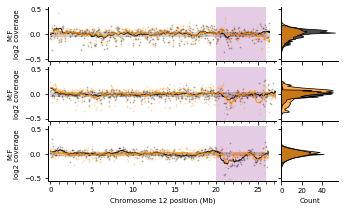

In [8]:
# --- PLOT COVERAGE
params = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'lines.markersize': 1,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'text.usetex': False,
    'figure.figsize': [5.2, 3.2]
}
plt.rcParams.update(params)


marker_alpha = 0.20
line_alpha = 0.90

# build figure and axes
ymin, ymax = -0.55, 0.55
ylab = 'M:F\nlog2 coverage'


fig, axes = plt.subplots(
                    nrows=len(rivers), ncols=2, sharex='col', sharey='col',
                    gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.035})

from matplotlib.ticker import AutoMinorLocator
minorLocator = AutoMinorLocator()

for i, river in enumerate(rivers):
    ax = axes[i][0]
    axHist = axes[i][1]
    
    for j, pop in enumerate(pops):
        _df = sex_df.loc[(sex_df['river'] == river) & (sex_df['pop'] == pop)]
        _ = ax.plot(_df['pos'], _df['logCov'], marker='o',
                    linewidth=0, color=colours[j], alpha=marker_alpha)
        _ = ax.plot(_df['pos'], _df['logCov_roll'], marker='o',
                    markersize=0, color=colours[j], alpha=line_alpha,
                   label=pop)

        # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
        y, bins = np.histogram(_df['logCov'].dropna(), bins=100)
        x = 0.5 * (bins[1:] + bins[:-1])
        lowess = sm.nonparametric.lowess(y, x, frac=0.1)
        _ = axHist.plot(lowess[:, 1], lowess[:, 0], color='k', lw=0.75)
        _ = axHist.fill_betweenx(lowess[:, 0], lowess[:, 1], facecolor=colours[j], alpha=0.7)
        _ = axHist.set_ylim(ax.get_ylim())
        _ = axHist.yaxis.set_ticklabels([])

    xmax = _df['pos'].max()
    _ = ax.set_xlim(-250000, xmax + 1000000)
    _ = ax.set_ylim(ymin, ymax)

    # bootstrap
    boot_low, boot_high = boots[river]['logCov']
    ax = drawBoot(ax, boot_low, boot_high)
    
    # strata
    if strata:
        ax = drawStrata(ax, strata)

    _ = ax.set_ylabel(ylab)

    # de-spine
    ax = despine(ax, ['top', 'right'])
    axHist = despine(axHist, ['top', 'right'])

_ = axHist.set_xlim(0, axHist.get_xlim()[1])
_ = axHist.set_xticks(np.arange(0, axHist.get_xlim()[1], 20))
_ = axHist.set_xlabel('Count')

ax = finalizeFig(ax)

#fig.tight_layout()
plt.subplots_adjust(hspace = .1)
fig.savefig('chr-sex.cov.{}'.format(out_suffix), format='pdf', bbox='tight')

In [9]:
import scipy.stats as stats
l_results = []
for r in rivers:
    _df = sex_df.loc[sex_df['river'] == r].dropna(how='any')
    s, p = stats.kruskal(
                    _df.loc[_df['pop'] == pops[0]]['logCov'], _df.loc[_df['pop'] == pops[1]]['logCov'])
    l_results.append((r, pops[0], pops[1], s, p))
df_stats = pd.DataFrame.from_records(
                        l_results, columns=['River', 'Pop1', 'Pop2', 'Statistic', 'p-value'])
df_stats

,River,Pop1,Pop2,Statistic,p-value
0,Aripo,High,Low,0.431259,0.511372
1,Quare,High,Low,12.358343,0.000439
2,Yarra,High,Low,0.022588,0.880533


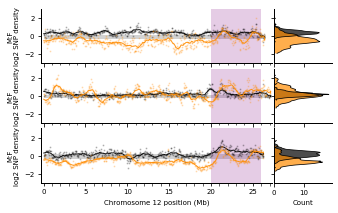

In [10]:
# --- PLOT SNP
params = {
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.linewidth': 1,
    'lines.linewidth': 1,
    'lines.markersize': 1,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'text.usetex': False,
    'figure.figsize': [5.2, 3.2]
}
plt.rcParams.update(params)


marker_alpha = 0.20
line_alpha = 0.90

# build figure and axes
ymin, ymax = -3, 3
ylab = 'M:F\nlog2 SNP density'

fig, axes = plt.subplots(
                    nrows=len(rivers), ncols=2, sharex='col', sharey='col',
                    gridspec_kw={'width_ratios': [4, 1], 'wspace': 0.015})

from matplotlib.ticker import AutoMinorLocator
minorLocator = AutoMinorLocator()


for i, river in enumerate(rivers):
    ax = axes[i][0]
    axHist = axes[i][1]

    for j, pop in enumerate(pops):
        _df = sex_df.loc[(sex_df['river'] == river) & (sex_df['pop'] == pop)]
        _ = ax.plot(_df['pos'], _df['logSnp'], marker='o',
                    linewidth=0, color=colours[j], alpha=marker_alpha)
        _ = ax.plot(_df['pos'], _df['logSnp_roll'], marker='o',
                    markersize=0, color=colours[j], alpha=line_alpha,
                   label=pop)

        # https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way
        y, bins = np.histogram(_df['logSnp'].dropna(), bins=100)
        x = 0.5 * (bins[1:] + bins[:-1])
        lowess = sm.nonparametric.lowess(y, x, frac=0.1)
        _ = axHist.plot(lowess[:, 1], lowess[:, 0], color='k', lw=0.75)
        _ = axHist.fill_betweenx(lowess[:, 0], lowess[:, 1], facecolor=colours[j], alpha=0.7)
        _ = axHist.set_ylim(ax.get_ylim())
        _ = axHist.yaxis.set_ticklabels([])

    xmax = _df['pos'].max()
    _ = ax.set_xlim(-250000, xmax + 1000000)
    _ = ax.set_ylim(ymin, ymax)
    
    # bootstrap
    boot_low, boot_high = boots[river]['logSnp']
    ax = drawBoot(ax, boot_low, boot_high)
    
    # strata
    if strata:
        ax = drawStrata(ax, strata)

    _ = ax.set_ylabel(ylab)

    # de-spine
    ax = despine(ax, ['top', 'right'])
    axHist = despine(axHist, ['top', 'right'])

_ = axHist.set_xlim(0, axHist.get_xlim()[1])
_ = axHist.set_xlabel('Count')

ax = finalizeFig(ax)

#fig.tight_layout()
plt.subplots_adjust(hspace = .1)
fig.savefig('chr-sex.snp.{}'.format(out_suffix), format='pdf', bbox='tight')